In [55]:
from scipy.io import loadmat
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

gaussian = loadmat('ids2.mat')
#print(banana)


# Extract the variables
class_num = gaussian['class_num']
data = gaussian['data']
label = gaussian['label']

# Convert variables to DataFrames
class_num_df = pd.DataFrame(class_num, columns=['class_num'])
data_df = pd.DataFrame(data, columns=['feature1', 'feature2'])
true_labels = pd.DataFrame(label, columns=['label'])

# Concatenate the DataFrames horizontally
df = pd.concat([class_num_df, data_df, true_labels], axis=1)

# Perform Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['feature1', 'feature2']])

# Update the scaled data in the DataFrame
df['feature1'] = scaled_data[:, 0]
df['feature2'] = scaled_data[:, 1]
data = df[['feature1', 'feature2']].values
print(data)

[[0.52110467 0.43632736]
 [0.30822996 0.54883026]
 [0.8886487  0.26948179]
 ...
 [0.14675846 0.61141549]
 [0.25119438 0.57309588]
 [0.66721436 0.92168363]]


In [56]:
print(len(data))

3200


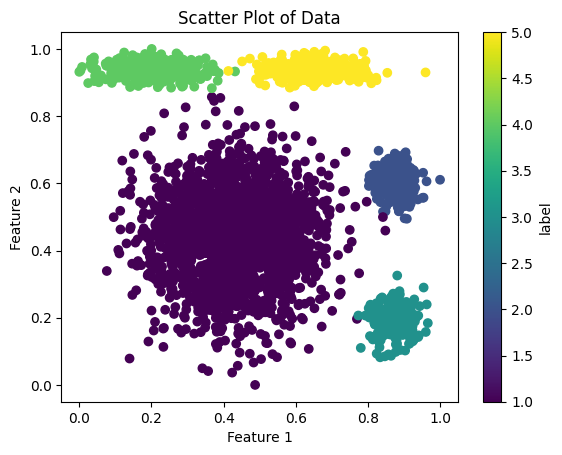

In [57]:
import matplotlib.pyplot as plt

# Plot the data
plt.scatter(df['feature1'], df['feature2'], c=label, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Data')
plt.colorbar(label='label')
plt.show()

In [58]:
import math

def oghlidos_fasele(p1, p2):
    return math.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(p1, p2)))


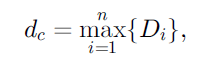

In [59]:
distances = []

import numpy as np
my_distance = []
distances = []

for i in range(len(data)):
    min_distance = np.inf
    for j in range(len(data)):
        if i != j:
            distance = oghlidos_fasele(data[i] , data[j])

            if distance < min_distance:
                min_distance = distance
    distances.append(min_distance)

# Calculate the maximum distance, dc
dc = max(distances)
print(dc)

0.1060130896350791


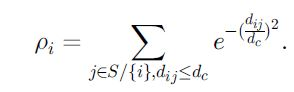

In [60]:

def calculate_density(dataset, dc):
    n = len(dataset)
    densities = []

    for i in range(n):
        sigma =0
       # di_min = float('inf')  # Initialize with a large value
        for j in range(n):
          dij = oghlidos_fasele(dataset[i] , dataset[j])
          if i!=j and dij <= dc :


              sigma += math.exp(-((dij/dc)**2))

                  # Calculate the Euclidean distance
        densities.append(sigma)


    return densities






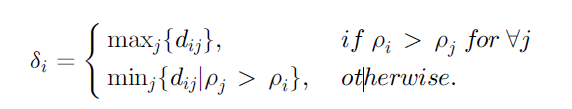

In [61]:
from tqdm import tqdm
def upward_distances(dataset, densities):
    n = len(dataset)
    distances = np.zeros(n)

    for i in tqdm(range(n)):
        if densities[i] == np.max(densities):
          distances[i] = np.max([oghlidos_fasele(dataset[i], dataset[j]) for j in range(n) ])
        else :
          min_distance = np.inf
          for j in range(n):
            if (densities[j] > densities[i]) and (i != j):
                distance = oghlidos_fasele(dataset[i], dataset[j])
                min_distance = min(min_distance, distance)
          distances[i] = min_distance

    return distances

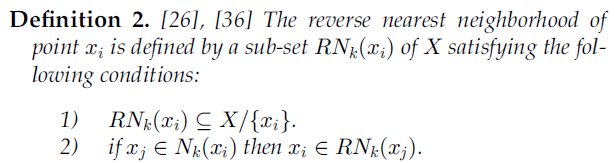

In [62]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def calculate_reverse_nearest_neighbors(data, k):
    n = len(data)
    RNN = []

    # Create k-NN model
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model with the data
    knn.fit(data, range(n))

    # Get the k nearest neighbors for each point
    _, indices = knn.kneighbors(data)

    # Store the reverse nearest neighbors
    for i in range(n):
        RNNi = [j for j in range(n) if i in indices[j] and j != i]

        RNN.append(RNNi)
    rnn_count = [len(RNNi) for RNNi in RNN]

    return rnn_count


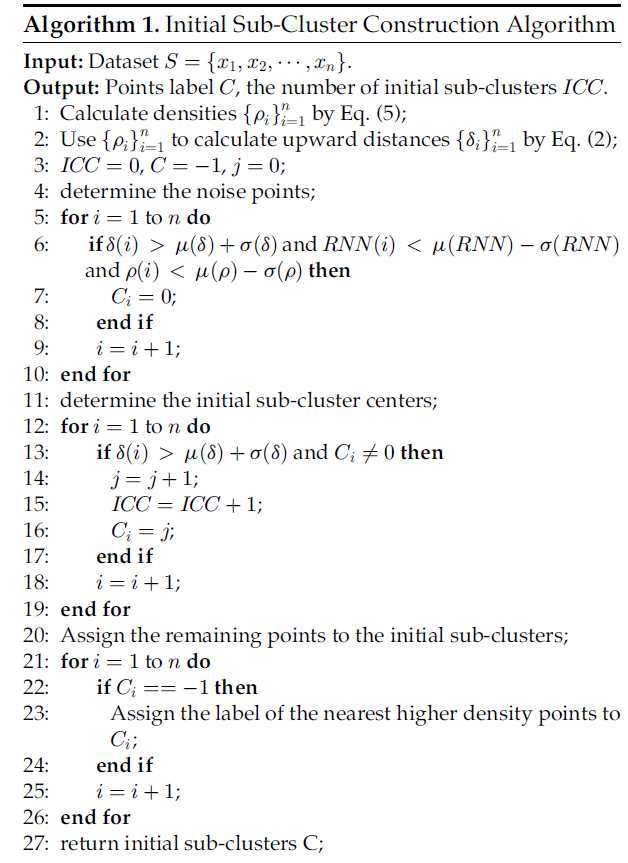

In [63]:
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

######### algo1
n = len(data)
C_values = -np.ones(n)  # ci = -1
ICC = 0
j = 0

densities = calculate_density(data, dc)  # 1

distances = upward_distances(data, densities)  # 2

RNN = calculate_reverse_nearest_neighbors(data, 5)  # 3

mean_density = np.mean(densities)
std_density = np.std(densities)

mean_upward = np.mean(distances)
std_upward = np.std(distances)

mean_RNN = np.mean(RNN)
std_RNN = np.std(RNN)
print(mean_RNN)
print(std_upward)

for i in tqdm(range(len(data))):  # determine noise
    data_i = data[i]
    density_i = densities[i]
    upward_i = distances[i]
    RNNi = RNN[i]

    if (density_i < mean_density - std_density) and (upward_i > mean_upward + std_upward) and (RNNi < mean_RNN - std_RNN):
        C_values[i] = 0


cluster_centers = []
for i in range(len(data)):  # determine subcluster centers

    data_i = data[i]
    density_i = densities[i]
    upward_i = distances[i]

    if upward_i > (mean_upward + std_upward) and C_values[i] != 0:

        j = j + 1
        ICC = ICC + 1
        C_values[i] = j

        cluster_centers.append( (i , ICC) )


distances = [] # store and sort distances for each point i asceding
for i in range(len(data)):
    distances_i = []
    for j in range(len(data)):
        if i != j:
            distance = oghlidos_fasele(data[i], data[j])
            distances_i.append((j, distance))
    distances_i.sort(key=lambda x: x[1])  # Sort distances by ascending order
    distances.append(distances_i)

for i in range(len(data)):  # Assign remaining points to subclusters
    if C_values[i] == -1:
      for idx, distance in distances[i]:
        if C_values[idx] != -1 and C_values[idx] !=0 :
          if densities[idx] > densities[i]:
              C_values[i] = C_values[idx]
              break





100%|██████████| 3200/3200 [00:24<00:00, 128.31it/s]


4.0
0.01921471450159022


100%|██████████| 3200/3200 [00:00<00:00, 446143.23it/s]


In [64]:
print(cluster_centers)

[(67, 1), (163, 2), (305, 3), (321, 4), (373, 5), (426, 6), (654, 7), (811, 8), (815, 9), (824, 10), (1019, 11), (1052, 12), (1167, 13), (1185, 14), (1217, 15), (1236, 16), (1247, 17), (1316, 18), (1379, 19), (1419, 20), (1429, 21), (1475, 22), (1524, 23), (1588, 24), (1670, 25), (1751, 26), (1796, 27), (1832, 28), (1869, 29), (1906, 30), (1953, 31), (2273, 32), (2394, 33), (2457, 34), (2507, 35), (2525, 36), (2575, 37), (2592, 38), (2659, 39), (2711, 40), (2720, 41), (2731, 42), (2973, 43), (2979, 44), (3120, 45)]


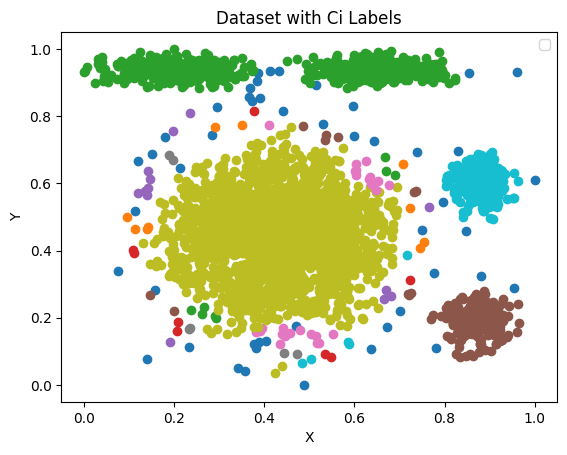

In [65]:
import matplotlib.pyplot as plt

def plot_dataset(data, Ci):
    unique_labels = np.unique(Ci)

    for label in unique_labels:
        x = data[Ci == label, 0]  # Assuming x-coordinates are in the first column of data
        y = data[Ci == label, 1]  # Assuming y-coordinates are in the second column of data
        plt.scatter(x, y)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Dataset with Ci Labels")
    plt.legend()
    plt.show()


plot_dataset(data, C_values)


In [66]:
cluster_counts = {}
for ci in C_values:
    if ci != -1:
        if ci in cluster_counts:
            cluster_counts[ci] += 1
        else:
            cluster_counts[ci] = 1

for ci, count in cluster_counts.items():
    print(f"Cluster {ci}: {count} points")

Cluster 18.0: 1869 points
Cluster 35.0: 198 points
Cluster 12.0: 396 points
Cluster 0.0: 33 points
Cluster 22.0: 396 points
Cluster 19.0: 199 points
Cluster 1.0: 1 points
Cluster 2.0: 5 points
Cluster 4.0: 6 points
Cluster 10.0: 8 points
Cluster 11.0: 2 points
Cluster 16.0: 12 points
Cluster 21.0: 4 points
Cluster 7.0: 2 points
Cluster 20.0: 5 points
Cluster 39.0: 2 points
Cluster 3.0: 2 points
Cluster 5.0: 2 points
Cluster 6.0: 2 points
Cluster 44.0: 3 points
Cluster 26.0: 11 points
Cluster 23.0: 2 points
Cluster 17.0: 2 points
Cluster 25.0: 3 points
Cluster 38.0: 4 points
Cluster 15.0: 4 points
Cluster 8.0: 1 points
Cluster 9.0: 2 points
Cluster 32.0: 2 points
Cluster 13.0: 1 points
Cluster 14.0: 1 points
Cluster 24.0: 2 points
Cluster 31.0: 2 points
Cluster 27.0: 1 points
Cluster 28.0: 2 points
Cluster 29.0: 1 points
Cluster 30.0: 1 points
Cluster 33.0: 2 points
Cluster 34.0: 1 points
Cluster 36.0: 1 points
Cluster 37.0: 1 points
Cluster 40.0: 1 points
Cluster 41.0: 1 points
Cluster

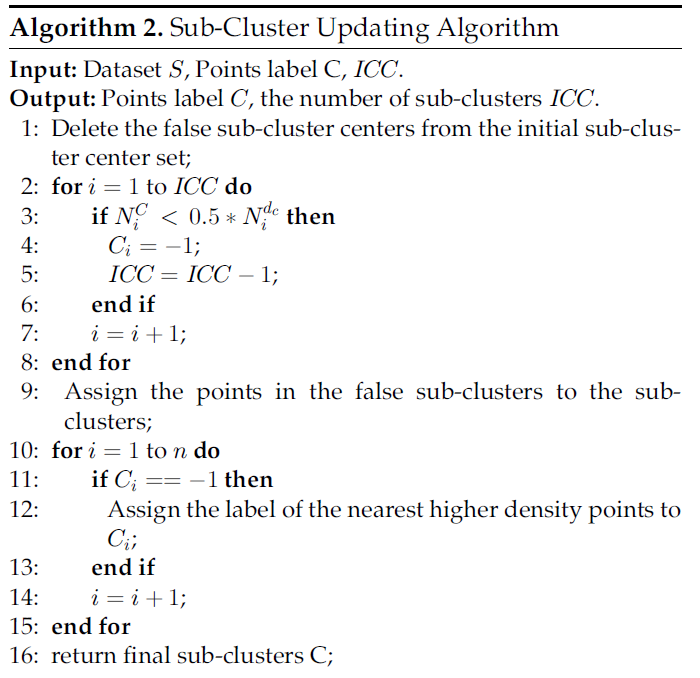

In [67]:
print((cluster_centers[0]))
print(ICC)

(67, 1)
45


In [68]:
#### Delete the false sub-cluster centers from the initial sub-cluster center set


new_cluster_centers = []
for i in range(1 , ICC + 1 ) :

  points_in_dc_radius = []

  points = [idx for idx, ci_value in enumerate(C_values) if ci_value == i]  # Find points belonging to the current subcluster
  new_cluster_centers.append(cluster_centers[i-1])
  print(data[((cluster_centers[i-1])[0])])
  Nc = len(points)
  cluster_center = data[ (cluster_centers[i-1])[0] ]

  points_in_dc_radius = [idx for idx, point in enumerate(data) if oghlidos_fasele(cluster_center, point) <= dc]  # Find points within radius dc from the center
  Ndc =  len(points_in_dc_radius)

  if Nc < 0.5 * Ndc :
    new_cluster_centers.remove(cluster_centers[i-1])

    for point_idx in points:
            C_values[point_idx] = -1
    ICC = ICC -1



#### Assign the points in the false sub-clusters to the subclusters

for i in range(len(data)):
    if C_values[i] == -1:
      for idx, distance in distances[i]:
        if C_values[idx] != -1 and C_values[idx] !=0 :
          if densities[idx] > densities[i]:
              C_values[i] = C_values[idx]
              break






[0.72321982 0.52637432]
[0.2661658  0.23178734]
[0.20985921 0.187571  ]
[0.14081941 0.56570969]
[0.73114554 0.57535572]
[0.55341407 0.15063737]
[0.23459285 0.16972007]
[0.57491683 0.70378758]
[0.50384032 0.07685494]
[0.36744325 0.88313115]
[0.35058567 0.77455593]
[0.64162126 0.93698724]
[0.72411479 0.31349996]
[0.76518551 0.53046415]
[0.53436386 0.73022595]
[0.44141849 0.16968761]
[0.19875714 0.67044224]
[0.43980972 0.44925373]
[0.87261561 0.60381837]
[0.40410877 0.13199325]
[0.14278575 0.47045739]
[0.2188958  0.93768017]
[0.11112551 0.39134301]
[0.23517166 0.80826125]
[0.72127582 0.26850933]
[0.60373779 0.62353787]
[0.44455841 0.09609402]
[0.4392466  0.05705779]
[0.7173271  0.38654099]
[0.21336907 0.6460532 ]
[0.7451818  0.40610687]
[0.67065112 0.6353671 ]
[0.53548645 0.09164171]
[0.19155434 0.12921596]
[0.87090087 0.18616352]
[0.41038621 0.77362026]
[0.47264712 0.09280423]
[0.29562837 0.16602635]
[0.58488987 0.12684866]
[0.15143644 0.6875041 ]
[0.70841106 0.65847538]
[0.66762505 0.67

In [69]:
print(new_cluster_centers)


[(1052, 12), (1316, 18), (1379, 19), (1475, 22), (2507, 35)]


In [70]:
cluster_counts = {}
for ci in C_values:
    if ci != -1:
        if ci in cluster_counts:
            cluster_counts[ci] += 1
        else:
            cluster_counts[ci] = 1

for ci, count in cluster_counts.items():
    print(f"Cluster {ci}: {count} points")

Cluster 18.0: 1967 points
Cluster 35.0: 198 points
Cluster 12.0: 397 points
Cluster 0.0: 33 points
Cluster 22.0: 406 points
Cluster 19.0: 199 points


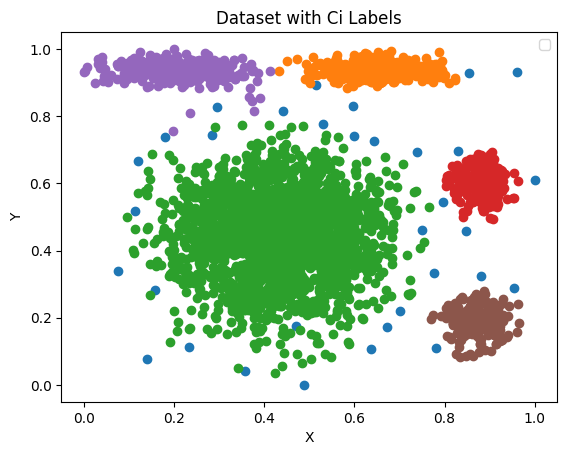

In [71]:
import matplotlib.pyplot as plt

def plot_dataset(data, Ci):
    unique_labels = np.unique(Ci)

    for label in unique_labels:
        x = data[Ci == label, 0]  # Assuming x-coordinates are in the first column of data
        y = data[Ci == label, 1]  # Assuming y-coordinates are in the second column of data
        plt.scatter(x, y)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Dataset with Ci Labels")
    plt.legend()
    plt.show()

# Assuming you have your dataset `data` and Ci labels `C_values` available
plot_dataset(data, C_values)

In [72]:
print(new_cluster_centers)

[(1052, 12), (1316, 18), (1379, 19), (1475, 22), (2507, 35)]


In [73]:
def find_min_distance_between_clusters(cluster1, cluster2):
    min_distance = np.inf
    for point1 in cluster1:

        for point2 in cluster2:
            distance = oghlidos_fasele(data[point1], data[point2] )  # Calculate the distance between the two points
            if distance < min_distance:
                pi = point1
                pj = point2
                min_distance = distance
    return min_distance , pi , pj

In [74]:
def calculate_merging_radius( data , dc , C_values):
    noise_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == 0]  # Find the indices of noise points

    if len(noise_points) == 0:
        merging_radius = dc  # If no noise points, merging radius equals dc
    else:
        min_distances = []
        for i in range(len(data)):
            if i not in noise_points:
                min_distance = np.inf
                for j in range(len(data)):
                    if j != i and j not in noise_points:
                        distance = oghlidos_fasele(data[i], data[j])  # Calculate the distance between points
                        if distance < min_distance:
                            min_distance = distance
                min_distances.append(min_distance)

        merging_radius = max(min_distances)  # Find the maximum minimum distance

    return merging_radius


In [75]:
def calculate_boundary_points(data, C_values, densities, ICC):
    boundary_points = []

    # Find the boundary points
    for ci in range(1, ICC + 1):
        label = (new_cluster_centers[ci-1])[1]
        cluster_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == label]  # Find points belonging to the current subcluster
        average_density = np.mean([densities[idx] for idx in cluster_points])  # Calculate the average density of the subcluster
        boundary_points.extend([idx for idx in cluster_points if densities[idx] < average_density])  # Find the boundary points based on density

    return boundary_points

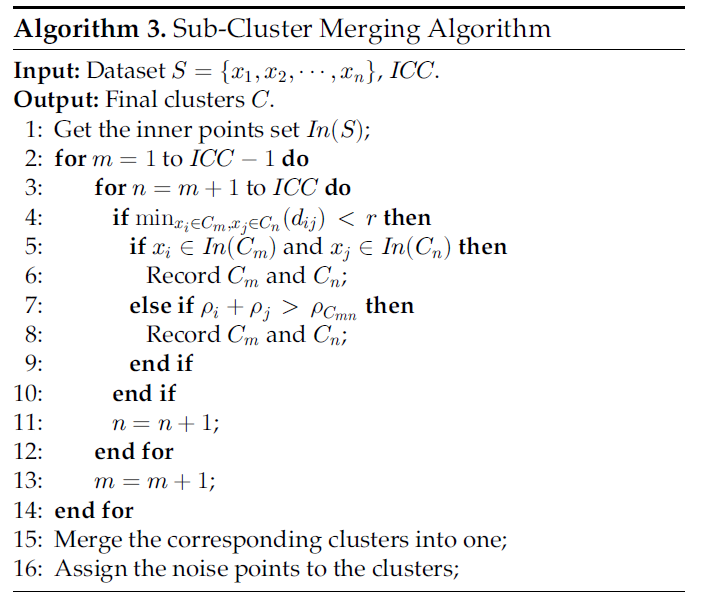

In [76]:
cluster_record = []
boundary_points = calculate_boundary_points(data, C_values, densities, ICC )
# Calculate inner points (subset In(X))
inner_points = [idx for idx in range(len(data)) if idx not in boundary_points]


for m in range ( 1 , ICC) :

  label_m = (new_cluster_centers[m-1])[1]

  n = m+1

  while n <= ICC :

    label_n = new_cluster_centers[n-1][1]

    cluster_m_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == label_m]  # Find points in subcluster Cm
    cluster_n_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == label_n]  # Find points in subcluster Cn

    density_Cm = densities[ ( new_cluster_centers[m - 1][0] ) ]
    density_Cn = densities[ ( new_cluster_centers[n - 1][0] ) ]
    density_Cmn = (density_Cm + density_Cn )  / 2

    min_dis , i_index , j_index = find_min_distance_between_clusters( cluster_m_points , cluster_n_points )
    r = calculate_merging_radius(data , dc , C_values)



    if min_dis < r :

          if (i_index in inner_points) and (j_index in inner_points):

            if (label_m , label_n) not in cluster_record :
               cluster_record.append((label_m, label_n))


          elif (densities[i_index] + densities[j_index]) > density_Cmn:

            if (label_m , label_n) not in cluster_record :
               cluster_record.append((label_m, label_n))
    n += 1






In [77]:
print(cluster_record)

[]


In [78]:
# Merge the corresponding clusters into one
for cluster_m, cluster_n in cluster_record:
    for idx, ci_value in enumerate(C_values):
        if ci_value == cluster_n:
            C_values[idx] = cluster_m

In [79]:
# Assign the noise points to the nearest clusters
for idx, ci_value in enumerate(C_values):
    if ci_value == 0:
        noise_point = data[idx]
        min_distance = np.inf
        nearest_cluster = -1

        for data_idx, data_point in enumerate(data):
            if data_idx != idx and C_values[data_idx] != 0:
                distance = oghlidos_fasele(noise_point, data_point)
                if distance < min_distance:
                    min_distance = distance
                    nearest_cluster = C_values[data_idx]

        C_values[idx] = nearest_cluster


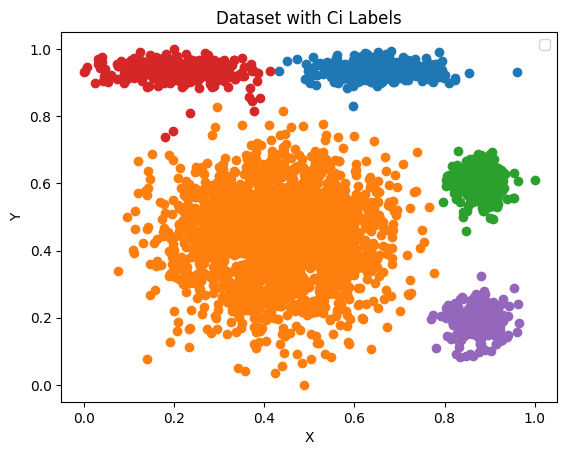

In [80]:
import matplotlib.pyplot as plt

def plot_dataset(data, Ci):
    unique_labels = np.unique(Ci)

    for label in unique_labels:
        x = data[Ci == label, 0]  # Assuming x-coordinates are in the first column of data
        y = data[Ci == label, 1]  # Assuming y-coordinates are in the second column of data
        plt.scatter(x, y)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Dataset with Ci Labels")
    plt.legend()
    plt.show()

# Assuming you have your dataset `data` and Ci labels `C_values` available
plot_dataset(data, C_values)

In [81]:
cluster_counts = {}
for ci in C_values:
    if ci != -1:
        if ci in cluster_counts:
            cluster_counts[ci] += 1
        else:
            cluster_counts[ci] = 1

for ci, count in cluster_counts.items():
    print(f"Cluster {ci}: {count} points")

Cluster 18.0: 1988 points
Cluster 35.0: 201 points
Cluster 12.0: 401 points
Cluster 22.0: 407 points
Cluster 19.0: 203 points


In [82]:
new_values = pd.DataFrame()
new_label = []
# Assign new labels to specific values in C_values
new_labels = []
for idx, ci_value in enumerate(C_values):

    if ci_value == 18:

        new_label = 1
        new_labels.append(new_label)

    elif ci_value == 12:
        new_label = 5
        new_labels.append(new_label)
    elif ci_value == 19:
        new_label = 2
        new_labels.append(new_label)
    elif ci_value == 22:
        new_label = 4
        new_labels.append(new_label)
    elif  ci_value == 35:
        new_label = 3
        new_labels.append(new_label)
    else:
        new_labels.append(ci_value)
print(len(C_values))
print(len(new_labels))
df_new_labels = pd.DataFrame({'new_labels': new_labels})
display(df_new_labels)

3200
3200


,new_labels
0,1
1,1
2,3
3,5
4,1
...,...
3195,1
3196,2
3197,1
3198,1


In [83]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics.cluster import normalized_mutual_info_score

# Flatten the true_labels and new_labels
new_label = df_new_labels["new_labels"].values.flatten()
true_label = true_labels["label"].values.flatten()

# Calculate accuracy
accuracy = accuracy_score(true_label, new_label)

# Calculate recall
recall = recall_score(true_label, new_label, average='macro')

# Calculate normalized mutual information score
nmi = normalized_mutual_info_score(true_label, new_label)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Normalized Mutual Information Score:", nmi)

Accuracy: 0.995625
Recall: 0.9978
Normalized Mutual Information Score: 0.9760293404157403
